In [1]:
%run ./'01 load.ipynb'
pd.options.display.float_format = '{0:,.0f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_rows = 100

In [2]:
len_predictions = 7
rate_death = 0.04014563012 # global as of 2020-03-18
rate_death = 0.008 # luca
rate_icu = 0.14
start_date = '2020-02-20'

In [3]:
germany = df[(df['country'] == 'Germany') & (df['date'] >= '2020-02-03' )]
# germany = df.groupby('date').sum().reset_index() # world
dates_new = pd.date_range(germany['date'].iloc[-1], periods=len_predictions)
df_new = pd.DataFrame(dates_new[1:], columns=['date'])
germany = germany.append(df_new, ignore_index=True)

In [4]:
germany['growth'] = germany['confirmed'].pct_change() * 100

In [5]:
len_before_start = (germany['date'] < start_date).sum()
len_after_start = (germany['date'] >= start_date).sum()

In [6]:
# prepare machine learning magic
y = germany.iloc[len_before_start:]['confirmed'].dropna()
x = list(range(len(y)))
# machine learning magic
from scipy.optimize import curve_fit
def func(x, a, d):
    return a**x + d
popt, pcov = curve_fit(func, x, y)
print(*popt)
print(*pcov)

1.4093339000263578 552.278156631928
[ 2.11857333e-06 -9.60346839e-02] [-9.60346839e-02  2.47039270e+04]


In [7]:
# get x values from predictor
predict = []
for i in range(len_after_start+len_predictions):
    prediction = func(i, *popt)
    prediction = 0 if prediction < 0 else round(prediction, -2)
    predict.append(prediction)
germany = germany.join(pd.DataFrame(enumerate(predict, len_before_start), columns=['id', 'predict']).set_index('id'))    

In [8]:
germany['growth_predict'] = germany['predict'].pct_change() * 100

In [9]:
# predict deaths based on prediction of cases and death rate (see top)
germany['predict_deaths'] = germany['predict'] * rate_death
germany['predict_icu'] = germany['predict'] * rate_icu

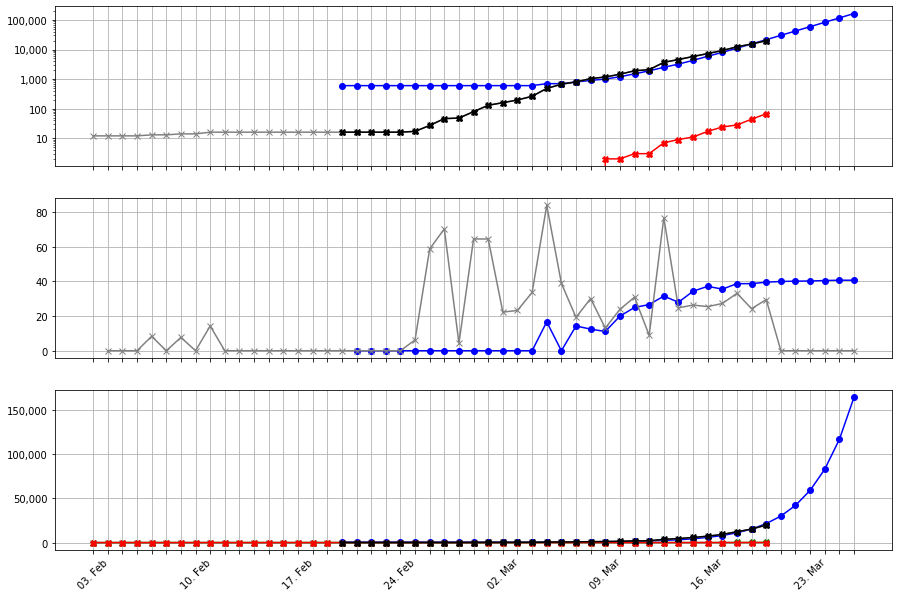

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
format_y = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
x = list(germany['date_string'])
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3,1,1)
ax1.grid(True)
ax1.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax1.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax1.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax1.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax1.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax1.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(format_y)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.grid(True)
ax2.plot(germany['date_string'], germany['growth_predict'], marker='o', color='blue')
ax2.plot(germany['date_string'], germany['growth'], marker='x', color='gray')
ax2.yaxis.set_major_formatter(format_y)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.grid(True)
ax3.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax3.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax3.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax3.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax3.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax3.set_xticklabels(labels=germany['date_string'], rotation=45)
ax3.yaxis.set_major_formatter(format_y)
labels = ax3.xaxis.get_ticklabels()
for label in labels:
    label.set_visible(False)
for label in labels[::7]:
    label.set_visible(True)
for ax in fig.get_axes():
    ax.label_outer()

In [11]:
germany.iloc[-len_predictions-5:]

,country,date_string,confirmed,deaths,recovered,date,growth,predict,growth_predict,predict_deaths,predict_icu
41,Germany,15. Mar,"5,795",11,46,2020-03-15,26,"4,300",34,34,602
42,Germany,16. Mar,"7,272",17,67,2020-03-16,25,"5,900",37,47,826
43,Germany,17. Mar,"9,257",24,67,2020-03-17,27,"8,000",36,64,"1,120"
44,Germany,18. Mar,"12,327",28,105,2020-03-18,33,"11,100",39,89,"1,554"
45,Germany,19. Mar,"15,320",44,113,2020-03-19,24,"15,400",39,123,"2,156"
46,Germany,20. Mar,"19,848",67,180,2020-03-20,30,"21,500",40,172,"3,010"
47,NaN,21. Mar,nan,nan,nan,2020-03-21,0,"30,100",40,241,"4,214"
48,NaN,22. Mar,nan,nan,nan,2020-03-22,0,"42,200",40,338,"5,908"
49,NaN,23. Mar,nan,nan,nan,2020-03-23,0,"59,200",40,474,"8,288"
50,NaN,24. Mar,nan,nan,nan,2020-03-24,0,"83,200",41,666,"11,648"
